In [236]:
import numpy as np
from scipy.signal import convolve2d
import scipy.fftpack as sfft
import matplotlib.pyplot as plt
from scatter_factors import get_delta_beta_mix
from xcompy import mixatten

h  = 6.62607015e-34      # Planck constant, J/Hz
c = 299792458.0          # speed of light, m/s
J_eV = 1.602176565e-19   # J per eV conversion

def get_wavelen(energy): # energy in keV -> wavelength in m
    return 1e-3*h*c/(energy*J_eV)

def get_mu(beta, energy): # energy in keV -> linear atten coeff in m^-1
    return 4*np.pi*beta/get_wavelen(energy)

laplace2d = np.array([[0,1,0],[1,-4,1],[0,1,0]]).astype(np.float32)

def get_t_j(x,y,r):  # sphere!
    if r**2 > x**2 + y**2:
        return 2*np.sqrt(r**2 - x**2 - y**2)
    else:
        return 0.0

def get_t_j_grid(x_vals, y_vals, r):
    t_j_grid = np.zeros([x_vals.size, y_vals.size]).astype(np.float32)
    for i,x in enumerate(x_vals):
        for j,y in enumerate(y_vals):
            t_j_grid[j,i] = get_t_j(x,y,r)
    return t_j_grid


# Setup

Recall our photon-counting signal model for material decomposition with phase information:
$$
m_i(x,y) = \int dE \, I_i(E) \, \eta(E)  
\exp \left\{ \sum_j \left[ - \mu_j(E) t_j(x,y)  + R  \delta_j(E) \nabla_{\perp}^2 t_j(x,y)  \right]   \right\}
$$

To solve for the CRLB, it is desirable to find an object shape where we can write $t_j(x,y)$ as a function of some single parameter to estimate (e.g. radius $r_j$ of a sphere, standard deviation $\sigma_j$ of a symmetric 3D Gaussian). It is convenient to write a general model for this approach so we can generalize to different object shapes. I will call the parameter of interest $A_j \equiv A_j(x,y) $, such that $t_j(x,y) \rightarrow t_j(A_j, x, y)$, with $j=1,2$. For our CRLB, we must compute the Fisher matrix $\mathcal{F}$:
$$
\mathcal{F}_{\alpha, \beta} =
\sum_i \frac{1}{m_i} \frac{\partial m_i}{\partial A_\alpha} \frac{\partial m_i}{\partial A_\beta}
$$

Then, the most tedious calculation for evaluating $\partial m_i / \partial A_j$ is $\partial \exp \left\{ ... \right\} / \partial A_j$, which we can generalize to:
$$
\frac{\partial}{\partial A_j} \exp \left\{  ... \right\} = 
\left( -\mu_j(E) \frac{\partial t_j}{\partial A_j} + R\delta_j(E) \frac{\partial \nabla_\perp^2 t_j}{\partial A_j} \right) 
\exp \left\{  ... \right\} 
$$

Here, we compute the CRLB using this a discretized version of this model and a known form of $t_j(x,y)$.

## With vs. without phase-contrast

To remove phase contrast (absorption only), just set the propagation distance $R=0$ (contact imaging).

# Sphere

Assume our object is constructed from two spheres with radius $r_j$, each of which is centered at the arbitrary origin of our coordinate system:
$$
    x^2 + y^2 + z^2 = r_j^2
$$
The projected thickness is equal to the path length of a ray through the sphere parallel to the $z$ axis:
$$
    t_j(x,y) =
    \begin{cases}
        \, 2 \sqrt{r_j^2 - x^2 - y^2} & \text{if } r_j^2 \leq x^2 + y^2 \\
        \, 0 & \text{else }
    \end{cases}
$$
Then, the continuous Laplacian is:
$$
    \nabla_\perp^2 t_j (x,y) = 
    \begin{cases}
    \, \frac{2(x^2 + y^2 - 2r_j^2)}{(r_j^2 - x^2 - y^2)^{3/2}} & \text{if } r_j^2 < x^2 + y^2 \\
    \, ? & \text{if } r_j^2 = x^2 + y^2 \\
    \, 0 & \text{else }
    \end{cases}
$$

This diverges when $x^2 + y^2 = r_j^2$, which is an issue for our continuous computation. As a solution, we instead apply the discrete 2D Laplace operator with finite difference method: \url{https://en.wikipedia.org/wiki/Discrete_Laplace_operator#Finite_differences}, and we solve the partial derivatives discretely.

In [17]:

laplace2d = np.array([[0,1,0],[1,-4,1],[0,1,0]]).astype(np.float32)

def get_t_j(x,y,r):  # sphere!
    if r**2 > x**2 + y**2:
        return 2*np.sqrt(r**2 - x**2 - y**2)
    else:
        return 0.0

def get_t_j_grid(x_vals, y_vals, r):
    t_j_grid = np.zeros([x_vals.size, y_vals.size]).astype(np.float32)
    for i,x in enumerate(x_vals):
        for j,y in enumerate(y_vals):
            t_j_grid[j,i] = get_t_j(x,y,r)
    return t_j_grid

def test_plot_obj(r):
    t_1 = get_t_j_grid(x_vals, x_vals, r)
    ddt_1 = convolve2d(t_1, laplace2d)
    fig, ax = plt.subplots(1,2,figsize=[8,3], dpi=300)
    ax[0].set_title('$t(x,y)$')
    m = ax[0].imshow(t_1)
    fig.colorbar(m, ax=ax[0])
    ax[1].set_title('$\\nabla_\perp^2 t(x,y)$')
    m = ax[1].imshow(ddt_1)
    fig.colorbar(m, ax=ax[1])
    fig.tight_layout()
    plt.show()

def test_plot_sig(m, dm1, dm2):

    fig, ax = plt.subplots(1,3,figsize=[11,3], dpi=300)
    ax[0].set_title('$m(x,y)$')
    m = ax[0].imshow(m)
    fig.colorbar(m, ax=ax[0])
    
    ax[1].set_title('$\partial m / \partial A_1$')
    m = ax[1].imshow(dm1)
    fig.colorbar(m, ax=ax[1])
    
    ax[2].set_title('$\partial m / \partial A_2$')
    m = ax[2].imshow(dm2)
    fig.colorbar(m, ax=ax[2])

    for axi in ax.ravel():
        axi.axis('off')
    fig.tight_layout()
    plt.show()

def test_plot_objsig(sig, r1, r2):
    t_1 = get_t_j_grid(x_vals, x_vals, r1)
    t_2 = get_t_j_grid(x_vals, x_vals, r2)

    fig, ax = plt.subplots(1,3,figsize=[11,3], dpi=300)
    ax[0].set_title('$t_1(x,y)$')
    m = ax[0].imshow(t_1)
    fig.colorbar(m, ax=ax[0])
    
    ax[1].set_title('$t_2(x,y)$')
    m = ax[1].imshow(t_2)
    fig.colorbar(m, ax=ax[1])
    
    ax[2].set_title('image')
    m = ax[2].imshow(sig)
    fig.colorbar(m, ax=ax[2])

    for axi in ax.ravel():
        axi.axis('off')
    fig.tight_layout()
    plt.show()

def get_m_mono(A_1, A_2, I_i, eta, prop_dist, mu_1, delta_1, mu_2, delta_2, x_vals):
    '''
    Requires external func `get_t_j_grid` to be defined for params A_j! 
    '''
    t_1 = get_t_j_grid(x_vals, x_vals, A_1)
    ddt_1 = convolve2d(t_1, laplace2d, mode='same')

    t_2 = get_t_j_grid(x_vals, x_vals, A_2)
    ddt_2 = convolve2d(t_2, laplace2d, mode='same')

    arg_1 = -mu_1*t_1 + prop_dist*delta_1*ddt_1
    arg_2 = -mu_2*t_2 + prop_dist*delta_2*ddt_2
        
    signal = I_i * eta * np.exp(arg_1 + arg_2)

    return signal


def get_dm_dA_mono(dx_1, dx_2, A_1, A_2, I_i, eta, prop_dist, mu_1, delta_1, mu_2, delta_2, x_vals, EPS=1e-8):
    '''
    applying FTC:
      f'(x) = lim_[h->0] (f(x+dx) - f(x))/dx
    Either dx1 or dx2 should be 0 for these partials.
    '''
    assert np.abs(dx_1)<EPS or np.abs(dx_2)<EPS  # confirm h1 or h2 = 0
    m_0 = get_m_mono(r_1, r_2, I_i, eta, prop_dist, mu_1, delta_1, mu_2, delta_2, x_vals)
    m_f = get_m_mono(r_1+dx_1, r_2+dx_2, I_i, eta, prop_dist, mu_1, delta_1, mu_2, delta_2, x_vals)
    dm_dA = (m_f - m_0)/(dx_1 + dx_2)
    return dm_dA

153x153 grid 	 1.0e-03 m FOV 	 6.5e-06 m px 	 4.3e+01 photons/px


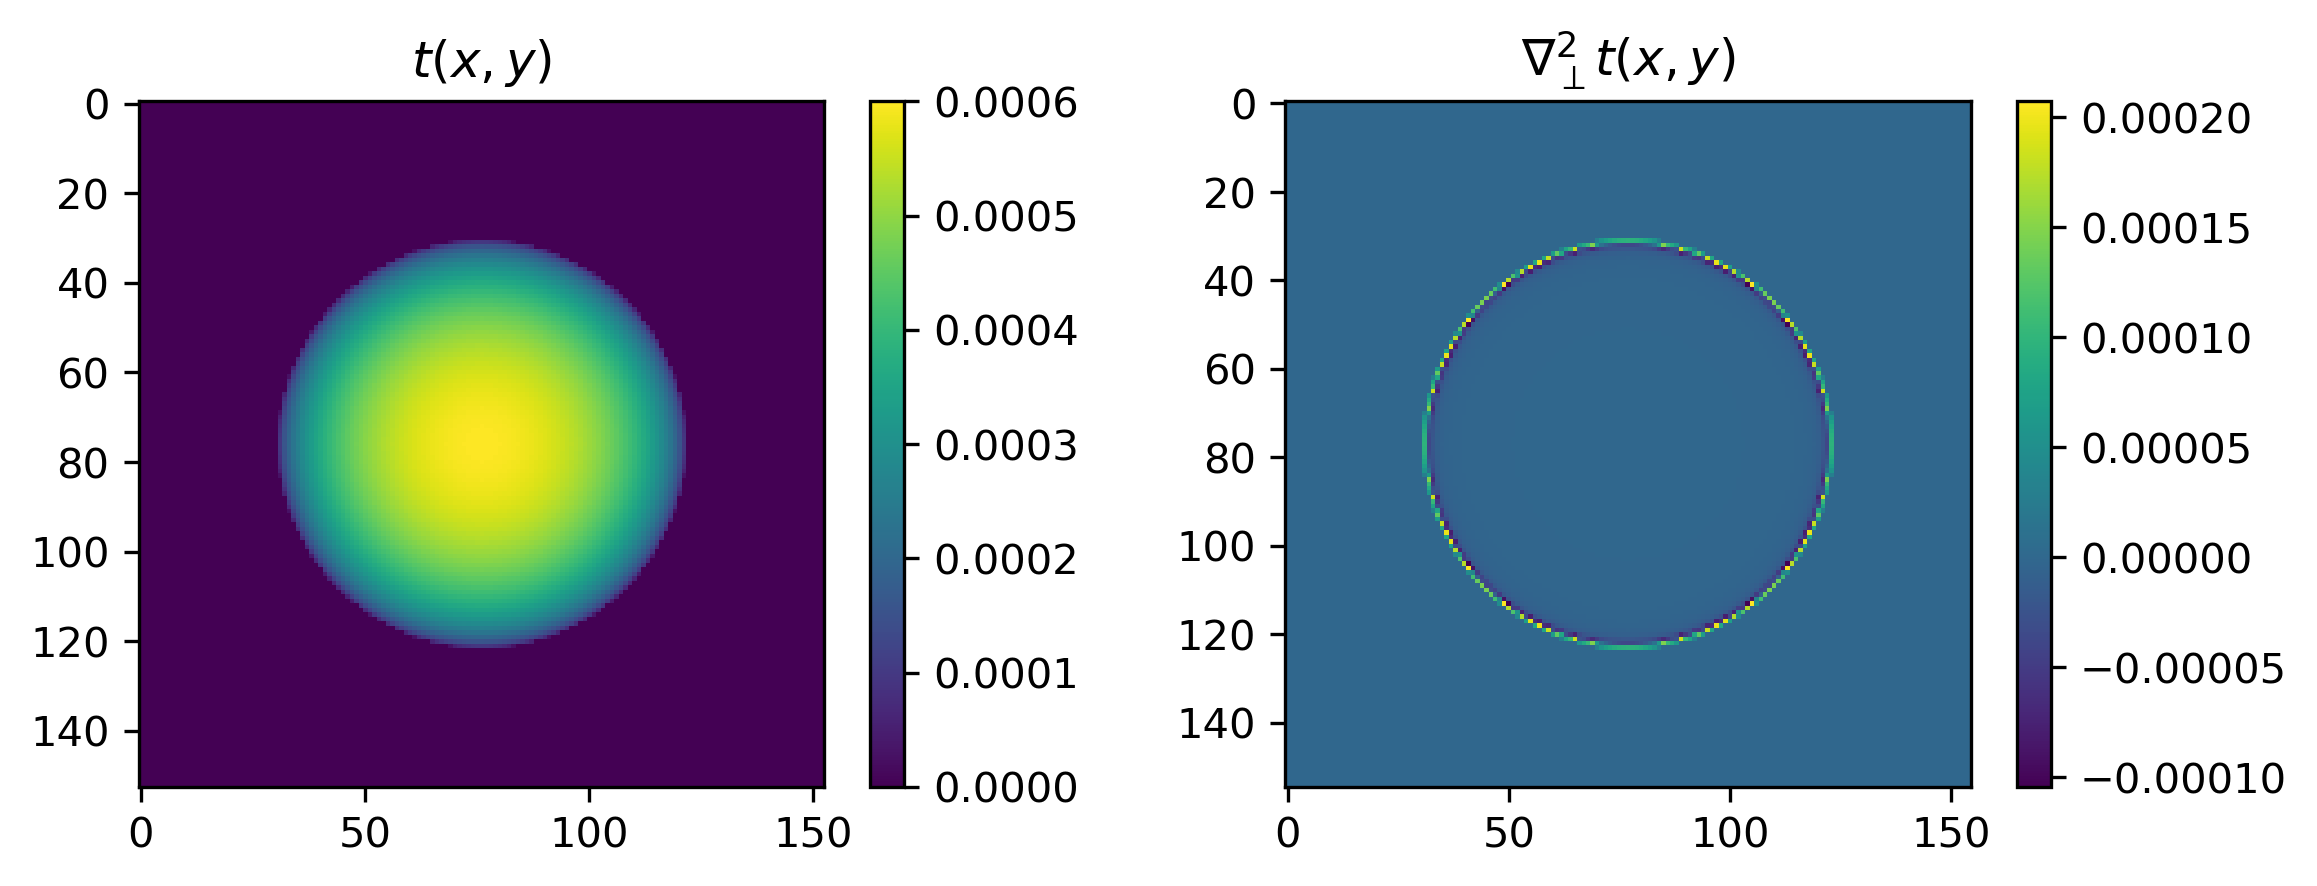

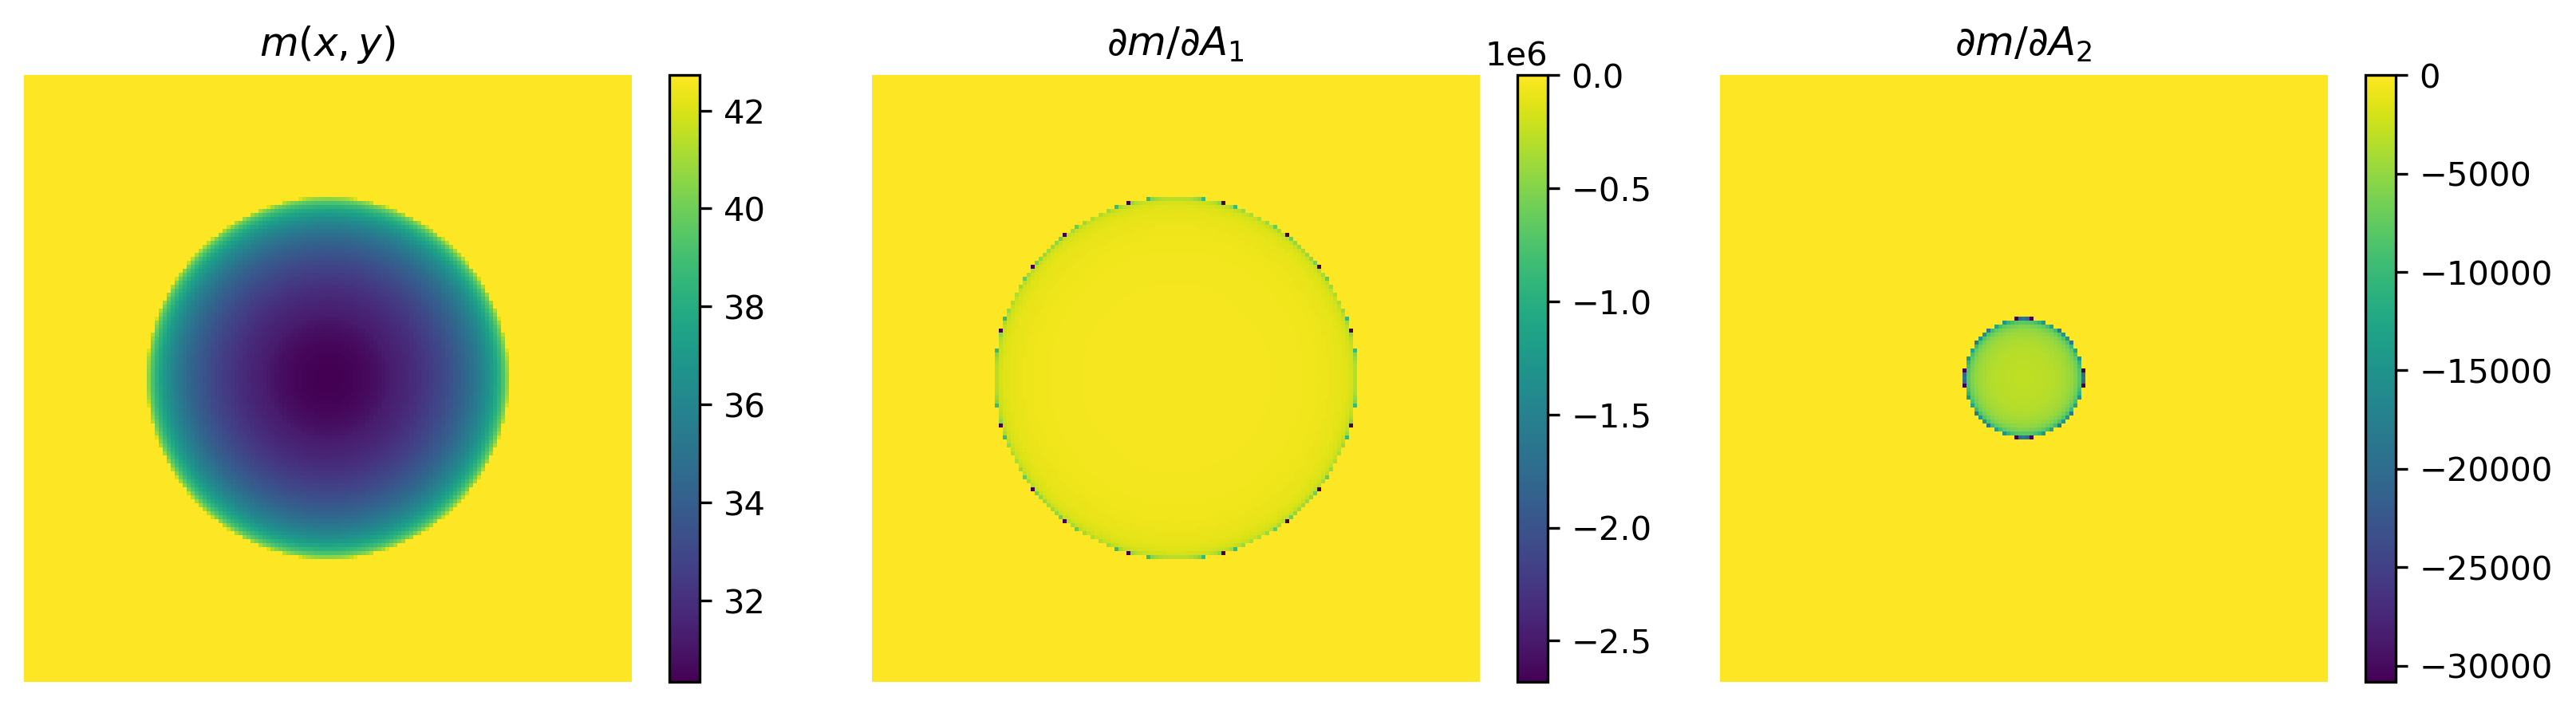

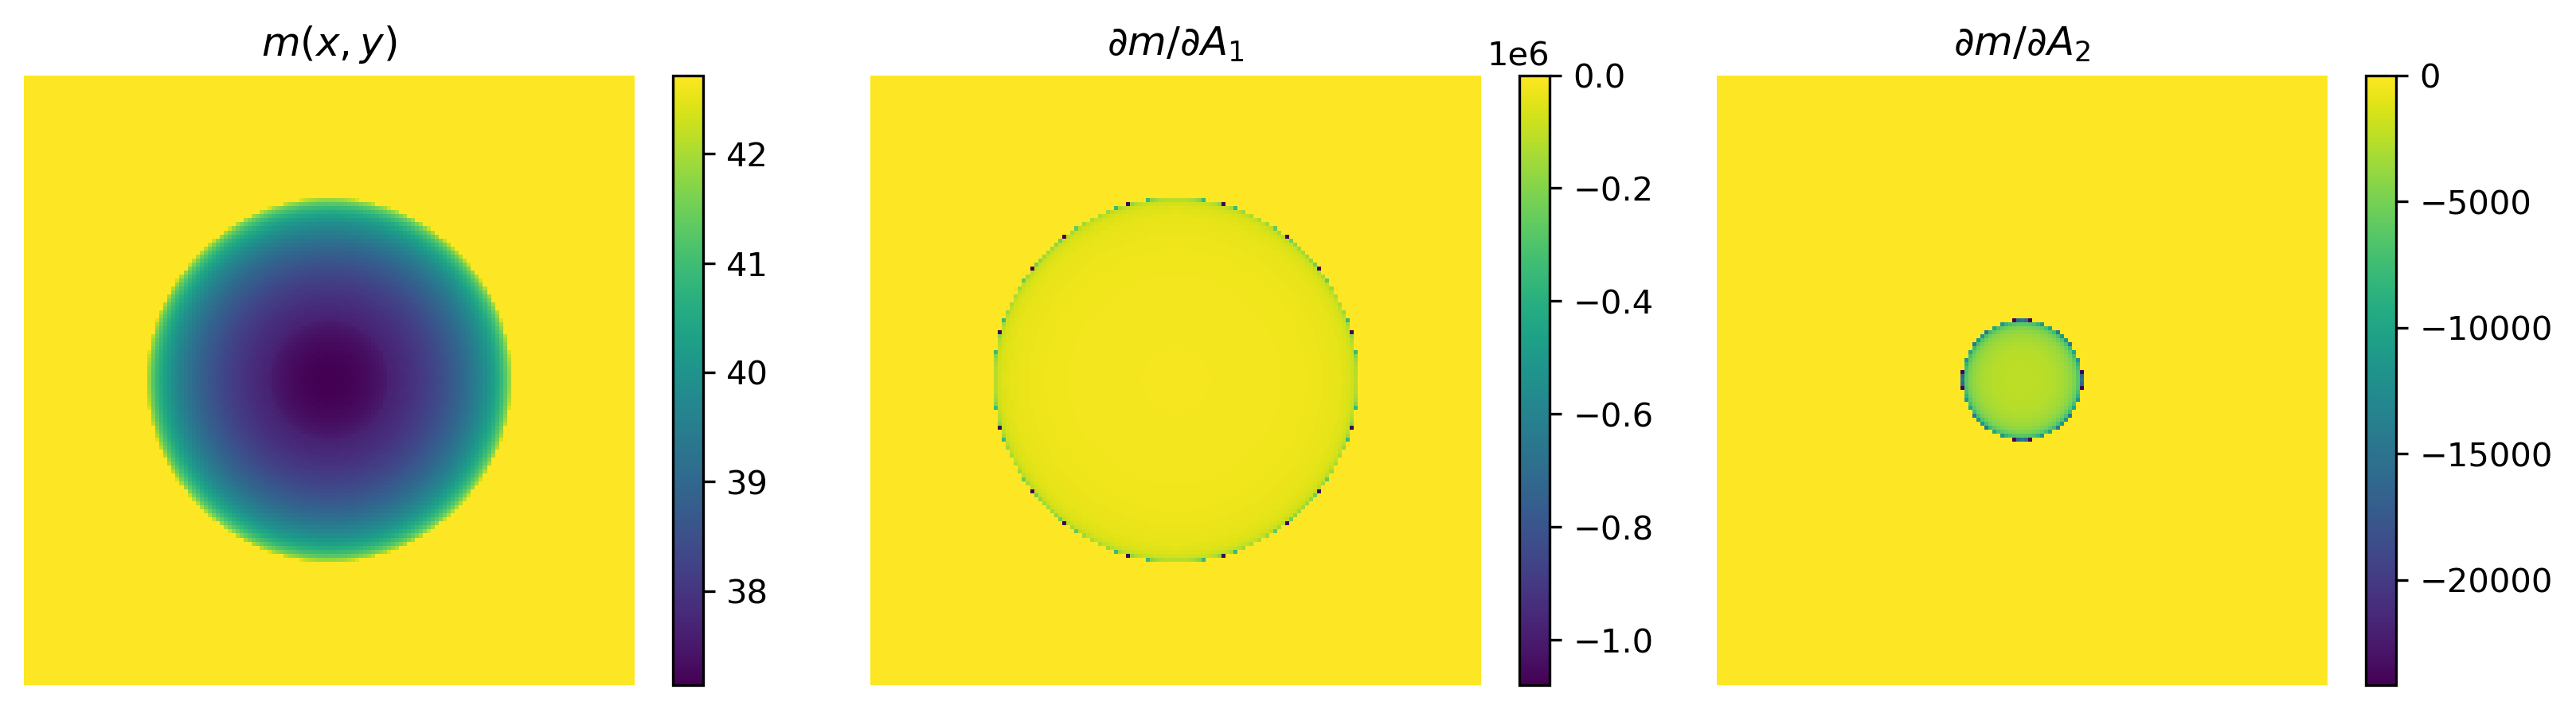

param 1 = 3.0e-04 	 stdev = 4.319e-07 	 --> 0.14%
param 2 = 1.0e-04 	 stdev = 2.370e-05 	 --> 23.70%
CPU times: user 2.7 s, sys: 13.2 ms, total: 2.72 s
Wall time: 2.72 s


In [83]:
%%time

####################################################
########## INPUTS ##################################


E_1, E_2 = 24.0, 34.0  # keV 
eta = 1.0 
prop_dist = 1000.0   # m
N_photons = 1e6   # number of photons per acquisition, to distribute over grid

## grid - symmetric (for now)
FOV = 1000.e-6
px_sz = 6.5e-6  
dx = .1e-6  # finite-difference partial derivatives

## material 1
r_1 = 300.e-6  
matname_1 = 'Aluminum'
matcomp_1 = 'Al(1.0)'  
density_1 = 2.699 # g/cm^3

## material 2
r_2 = 1.e-4
matname_2 = 'PMMA'
matcomp_2 = 'H(8.0541)C(59.9846)O(31.9613)' 
density_2 = 1.19 # g/cm^3


########## END OF INPUTS ###########################
####################################################


N_points = int(FOV/px_sz)
x_vals = np.linspace(-FOV/2, FOV/2, N_points).astype(np.float32) 
I_i = N_photons/ (N_points*N_points)  # photons per px

print(f'{N_points}x{N_points} grid \t {FOV:.1e} m FOV \t {px_sz:.1e} m px \t {I_i:.1e} photons/px')


test_plot_obj(r_1)

### init Fisher matrix
F = np.zeros([2,2], dtype=np.float64) 

### loop over different parameter samplings
for params in [[E_1, I_i, prop_dist],  [E_2, I_i, prop_dist]]:
    E, I, prop_dist = params

    ### set up the inputs
    mu_1 = 100*density_1*mixatten(matcomp_1, np.array([E]).astype(np.float64))[0] #m^-1
    mu_2 = 100*density_2*mixatten(matcomp_2, np.array([E]).astype(np.float64))[0] #m^-1
    delta_1, beta_1 = get_delta_beta_mix(matcomp_1, E, density_1) 
    #mu_1 = 0#get_mu(beta_1, E)
    obj_1 = [r_1, mu_1, delta_1]
    delta_2, beta_2 = get_delta_beta_mix(matcomp_2, E, density_2)  
    #mu_2 = 0#get_mu(beta_2, E)
    obj_2 = [r_2, mu_2, delta_2]

    ### compute the signal and partials
    sig = get_m_mono(r_1, r_2, I, eta, prop_dist, mu_1, delta_1, mu_2, delta_2, x_vals)
    dm_dA1 = get_dm_dA_mono(dx, 0, r_1, r_2, I, eta, prop_dist, mu_1, delta_1, mu_2, delta_2, x_vals)
    dm_dA2 = get_dm_dA_mono(0, dx, r_1, r_2, I, eta, prop_dist, mu_1, delta_1, mu_2, delta_2, x_vals)
    test_plot_sig(sig, dm_dA1, dm_dA2)

    ### add to crlb
    F[0,0] += np.sum(dm_dA1 * dm_dA1 / sig)
    F[0,1] += np.sum(dm_dA1 * dm_dA2 / sig)
    F[1,0] += np.sum(dm_dA2 * dm_dA1 / sig)
    F[1,1] += np.sum(dm_dA2 * dm_dA2 / sig)

### compute the crlb
Fi = np.linalg.inv(F)
crlb1 = Fi[0,0]
crlb2 = Fi[1,1]
s1 = np.sqrt(crlb1)
s2 = np.sqrt(crlb2)

print(f'param 1 = {r_1:.1e} \t stdev = {s1:.3e} \t --> {100*s1/r_1:.2f}%')
print(f'param 2 = {r_2:.1e} \t stdev = {s2:.3e} \t --> {100*s2/r_2:.2f}%')

(1.9760705e-11, 4.3149408e-11, 1.0)

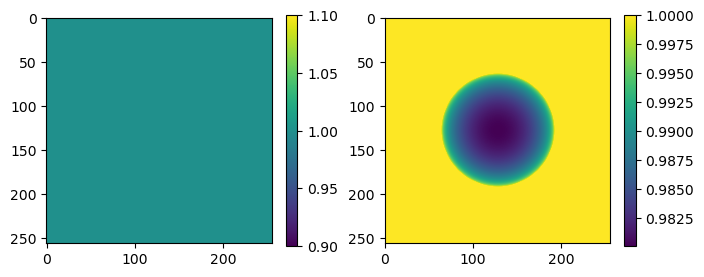

In [603]:
def get_m_mono(A_1, A_2, I_i, eta, prop_dist, mu_1, delta_1, mu_2, delta_2, x_vals):
    '''
    Requires external func `get_t_j_grid` to be defined for params A_j! 
    '''
    t_1 = get_t_j_grid(x_vals, x_vals, A_1)
    ddt_1 = convolve2d(t_1, laplace2d, mode='same')

    t_2 = get_t_j_grid(x_vals, x_vals, A_2)
    ddt_2 = convolve2d(t_2, laplace2d, mode='same')

    arg_1 = -mu_1*t_1 + prop_dist*delta_1*ddt_1
    arg_2 = -mu_2*t_2 + prop_dist*delta_2*ddt_2
        
    signal = I_i * eta * np.exp(arg_1 + arg_2)

    return signal

#plt.imshow(t_1)
laplace2d_5p = np.array([[0,1,0],
                      [1,-4,1],
                      [0,1,0]]).astype(np.float32)
laplace2d_7p = np.array([[0.25, 0.5, 0.25],
                      [0.5, -3.0, 0.5],
                      [0.25, 0.5, 0.25]]).astype(np.float32)
laplace2d_diags = np.array([[1,1,1],
                      [1,-8,1],
                      [1,1,1]]).astype(np.float32)
gfac = 1/3
laplace2d_rot = (1-gfac)*laplace2d_5p + \
                    gfac*np.array([[0.5, 0, 0.5],
                                  [0, -2, 0],
                                  [10.5, 0, 0.5]]).astype(np.float32)

RR = 1.0 # m
mm = get_m_mono(r_1, r_2, 1, 1, RR, mu_1, delta_1, mu_2, delta_2, x_vals)
ddt_1 = convolve2d(t_1, laplace2d_rot, mode='same')
fig,ax=plt.subplots(1,2,figsize=[8,3])
m=ax[0].imshow(np.exp(RR*delta_1*ddt_1))
fig.colorbar(m,ax=ax[0])
m=ax[1].imshow(np.exp(-mu_1*t_1))
fig.colorbar(m,ax=ax[1])
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-10,10))
delta_1, mu_1

xx = RR*delta_1*ddt_1  # small x --> e^x ~ e + x
np.mean(xx), np.std(xx), np.mean(np.exp(xx))

# Just images

307x307 grid 	 2.0e-03 m FOV 	 6.5e-06 m px 	 1.1e+01 photons/px


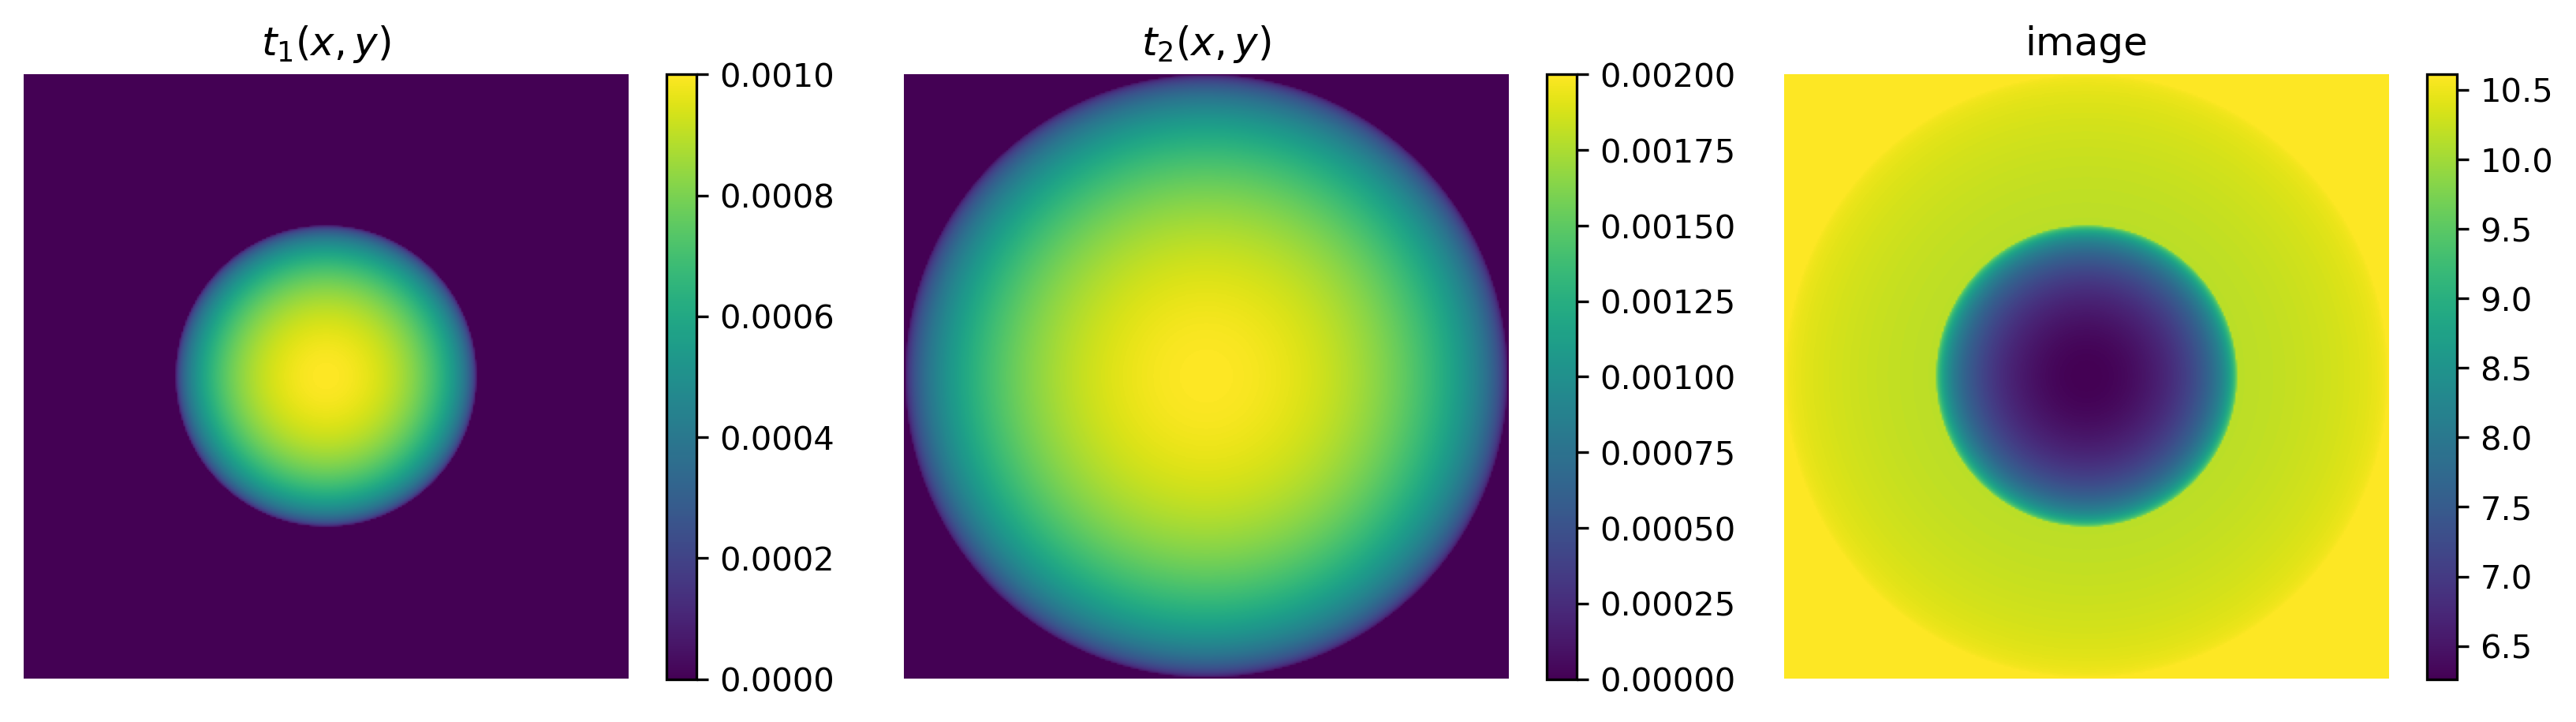

CPU times: user 2.14 s, sys: 1.92 ms, total: 2.14 s
Wall time: 2.18 s


In [22]:
%%time


E_1, E_2 = 24.0, 34.0  # keV 
eta = 1.0 
prop_dist = 1000.0   # m
N_photons = 1e6   # number of photons per acquisition, to distribute over grid

## grid - symmetric (for now)
FOV = 2.e-3
px_sz = 6.5e-6  
dx = .1e-6  # finite-difference partial derivatives

## material 1
r_1 = .5e-3  
matname_1 = 'Aluminum'
matcomp_1 = 'Al(1.0)'  
density_1 = 2.699 # g/cm^3

## material 2
r_2 = 1.e-3
matname_2 = 'PMMA'
matcomp_2 = 'H(8.0541)C(59.9846)O(31.9613)' 
density_2 = 1.19 # g/cm^3


########## END OF INPUTS ###########################
####################################################


N_points = int(FOV/px_sz)
x_vals = np.linspace(-FOV/2, FOV/2, N_points).astype(np.float32) 
I_i = N_photons/ (N_points*N_points)  # photons per px

print(f'{N_points}x{N_points} grid \t {FOV:.1e} m FOV \t {px_sz:.1e} m px \t {I_i:.1e} photons/px')

### loop over different parameter samplings
for params in [[E_1, I_i, prop_dist]]:
    E, I, prop_dist = params

    ### set up the inputs
    delta_1, beta_1 = get_delta_beta_mix(matcomp_1, E, density_1) 
    mu_1 = get_mu(beta_1, E)
    delta_2, beta_2 = get_delta_beta_mix(matcomp_2, E, density_2)  
    mu_2 = get_mu(beta_2, E)

    sig = get_m_mono(r_1, r_2, I, eta, prop_dist, mu_1, delta_1, mu_2, delta_2, x_vals)
    
test_plot_objsig(sig, r_1, r_2)


In [106]:
xx = np.ones([5,5])
np.pad(xx, [5,5])[5:-5]

array([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]])

In [104]:
Nx, Ny = 10,10
dx, dy = .5, .5

fx_vals = np.arange(-Nx/2, Nx/2, 1.0).astype(np.float64)
fy_vals = np.arange(-Ny/2, Ny/2, 1.0).astype(np.float64)
fx_vals /= Nx*dx  
fy_vals /= Ny*dy

print(fx_vals)

# mohan

Fy_wid = 1.0/(Ny*dy)
Fx_wid = 1.0/(Nx*dx)

y_coord = np.arange(0.0, float(Ny), 1.0)
y_coord[y_coord >= Ny//2] = Ny-y_coord[y_coord >= Ny//2]
x_coord = np.arange(0.0, float(Nx), 1.0)
x_coord[x_coord >= Nx//2] = Nx-x_coord[x_coord >= Nx//2]

y_coord, x_coord = y_coord*Fy_wid, x_coord*Fx_wid
#y_coord, x_coord = np.meshgrid(y_coord, x_coord, indexing='ij')

print(x_coord)


def propagate_wave(fO, prop_dist, wavelen, dx, dy, pad=True):
    '''
    compute wave after propagating distance prop_dist [mm]

    Does the Fresnel prop in the Fourier domain, which is best
    assuming pixel size dx=dy is larger than the cutoff,
        pix_liml = wavelen*prop_dist/(dx*min(Ny, Nx))
        pix_limh = wavelen*prop_dist/(dx*max(Ny, Nx))
    in the case pix_liml=pix_limh since Ny=Nx
    '''
    Nx, Ny = fO.shape        
    if pad:
        fO = np.pad(fO, [Nx, Ny], mode='reflect') # with zeros
        Nx, Ny = fO.shape        

    # get Fourier Transform of wave fO
    # we shift it so zero frequency is at the center
    FO = np.fft.fftshift(np.fft.fft2(fO))

    # get the discretely-sampled Fourier-space Fresnel operator
    fx, fy = get_fftfreqs(Nx, Ny, dx, dy)   # frequency samples
    H = np.exp(-np.pi*wavelen*prop_dist*1j*(fx**2 + fy**2))  

    # propogate wave FO to the detector -> FD
    FD = FO * H
    fD = np.fft.ifft2(FD)

    # # this defines `tran`, the Fresnel transform
    # fx, fy = get_fftfreqs(Nx, Ny, dx, dy)   # frequency samples
    # phase_mults = -np.pi*wavelen*prop_dist  # ?
    # Fxy_sq = phase_mults*(fx**2 + fy**2)
    # tran = np.exp(1j*Fxy_sq)  # this is H?
    if pad: # unpad
        fD = fD[Nx//3:-Nx//3, Ny//3:-Ny//3]
    
    return fD

[-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
[0.  0.2 0.4 0.6 0.8 1.  0.8 0.6 0.4 0.2]


# Fresnel propagation image

In [278]:
def tplot(img):
    kw = {'cmap':'gray', 'vmin':0, 'vmax':3.5}
    fig,ax=plt.subplots(1,2,figsize=[10,4], dpi=300)
    m = ax[0].imshow(np.abs(img), **kw)
    fig.colorbar(m, ax=ax[0])
    for axi in ax.ravel():
        axi.axis('off')
    fig.tight_layout()
    plt.show()

### set up the inputs
## grid - symmetric (for now)
px_sz = .3225e-6*2
FOV = px_sz*128 
N_points = int(FOV/px_sz)
upsampx=1
x_vals = np.linspace(-FOV/2, FOV/2, N_points).astype(np.float32) 
r_1 = 16e-6
t_1 = get_t_j_grid(x_vals, x_vals, r_1)
t_2 = get_t_j_grid(x_vals, x_vals, r_2)
print(f'{N_points}x{N_points} grid \t {FOV:.1e} m FOV \t {px_sz:.1e} m px \t {I_i:.1e} photons/px')

E = 20.0
f_obj_proj = modulate_wave(1, get_wavelen(E), t_1, t_2, delta_1, beta_1, delta_2, beta_2)
    

128x128 grid 	 8.3e-05 m FOV 	 6.4e-07 m px 	 4.3e+01 photons/px


5.551115123125783e-17

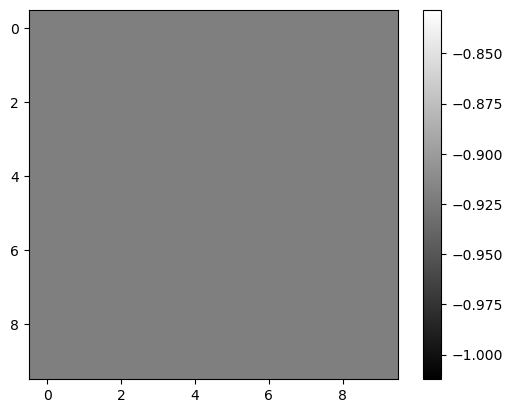

In [248]:
wavelen = 6.199210188637757e-12
k = 2*np.pi/wavelen
R = 20e-6
u = np.arange(-4,6,1)
v = u.copy()
U, V = np.meshgrid(u,v)  # this matches matlab script

wav = np.array([2 ,	3,	4,	5,	6,	7,	8,	9,	10,	11,
        3,	4,	5,	6,	7,	8,	9,	10,	11,	12,
        4,	5,	6,	7,	8,	9,	10,	11,	12,	13,
        5,	6,	7,	8,	9,	10,	11,	12,	13,	14,
        6,	7,	8,	9,	10,	11,	12,	13,	14,	15,
        7,	8,	9,	10,	11,	12,	13,	14,	15,	16,
        8,	9,	10,	11,	12,	13,	14,	15,	16,	17,
        9,	10,	11,	12,	13,	14,	15,	16,	17,	18,
        10,	11,	12,	13,	14,	15,	16,	17,	18,	19,
        11,	12,	13,	14,	15,	16,	17,	18,	19,	20]).reshape([10,10])
O = sfft.fftshift(sfft.fft2(wav))

H = np.exp(1j*k*R - 1j*np.pi*wavelen*R*(U**2 + V**2))

#plt.imshow(np.real(O), vmin=-100, vmax=100, cmap='gray')
plt.imshow(np.real(H), cmap='gray')#, vmin=-100, vmax=100, cmap='gray')
plt.colorbar()
#np.real(np.fft.fft2(wav))

np.std(np.imag(H))

In [269]:
def tplot(img, img2):
    kw = {'cmap':'gray'}#:, 'vmin':0, 'vmax':3.5}
    fig,ax=plt.subplots(1,2,figsize=[10,4], dpi=300)
    m = ax[0].imshow(np.abs(img), **kw)
    fig.colorbar(m, ax=ax[0])
    m = ax[1].imshow(np.abs(img2), **kw)
    fig.colorbar(m, ax=ax[1])
    for axi in ax.ravel():
        axi.axis('off')
    fig.tight_layout()
    plt.show()

def propwave1(fO, dx, dy, prop_dist, wavelen):
    Nx, Ny = fO.shape        
    FO = np.fft.fftshift(np.fft.fft2(fO))
    fx, fy = get_fftfreqs(Nx, Ny, dx, dy)   # frequency samples
    H = np.exp(-np.pi*wavelen*prop_dist*1j*(fx**2 + fy**2))  
    FD = FO * H
    fD = np.fft.ifft2(FD)
    return fD

def propwave2(fO, dx, dy, R, wavelen):
    wavenum = 2*np.pi/wavelen

    Ny, Nx = fO.shape #np.shape(fO)    print(Nx,dx)
    FO = np.fft.fftshift(np.fft.fft2(fO))
    fx, fy = get_fftfreqs(Nx, Ny, dx, dy)   # frequency samples
    print(np.exp(1j*wavenum*R))
    H = np.exp(1j*wavenum*R)*np.exp(-np.pi*wavelen*R*1j*(fx**2 + fy**2))  
    FD = FO * H
    fD = np.fft.ifft2(np.fft.ifftshift(FD))

    return fD

sig1 = propwave1(f_obj_proj, px_sz, px_sz, prop_dist, get_wavelen(E))
sig2 = propwave2(f_obj_proj, px_sz, px_sz, prop_dist, get_wavelen(E))
#sig = propagate_wave(f_obj_proj, prop_dist,  get_wavelen(E), px_sz, px_sz)

sig1 = np.abs(sig1)
sig2 = np.abs(sig2)
        
tplot(sig1, sig2)

numpy.complex128

256 3.25e-07 0.2 1.2019e+04
-1.5385e+06 (256, 256) 3.646593911764706e-11


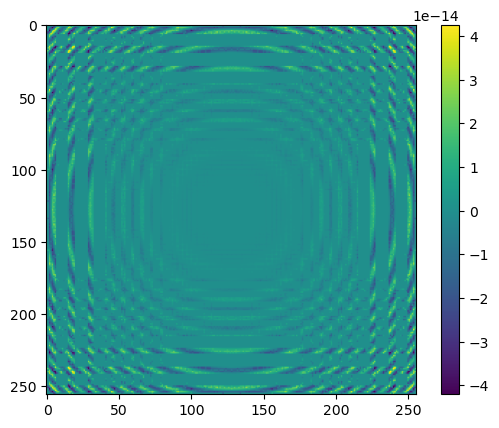

In [510]:
def tplot(img, img2):
    kw = {}#'cmap':'gray'}#:, 'vmin':0, 'vmax':3.5}
    fig,ax=plt.subplots(1,2,figsize=[10,4], dpi=300)
    m = ax[0].imshow(np.abs(img), **kw)
    fig.colorbar(m, ax=ax[0])
    m = ax[1].imshow(np.abs(img2), **kw)
    fig.colorbar(m, ax=ax[1])
    for axi in ax.ravel():
        axi.axis('off')
    fig.tight_layout()
    plt.show()

def propwave2(fO, dx, dy, R, wavelen):
    wavenum = 2*np.pi/wavelen

    Ny, Nx = fO.shape #np.shape(fO)    print(Nx,dx)
    FO = np.fft.fftshift(np.fft.fft2(fO))
    dfy, dfx = 1/(Ny*dy), 1/(Nx*dx)
    print(Nx, dx, R, f'{dfx:.4e}')

    u = (np.arange(Nx) - Nx//2 )*dfx  # + 1 to match matlab
    v = (np.arange(Ny) - Ny//2 )*dfy
    U, V = np.meshgrid(u, v)  # this matches matlab script
    print(f'{U[0,0]:.4e}', U.shape, wavelen)  # matlab = -1.5383e+6

    H = np.exp(-np.pi*wavelen*R*1j*(U**2 + V**2))  
    fD = np.fft.ifft2(np.fft.ifftshift(FO * H))
    return fD

    
#twavelen = get_wavelen(E)
#twavelen = 0.0619920965*1e-9         # 20 keV
#twavelen = 0.05166008041666667*1e-9  # 24 keV
twavelen = 0.03646593911764706*1e-9 # 34 keV

def propwave1(fO, dx, dy, prop_dist, wavelen):
    Nx, Ny = fO.shape        
    fx, fy = get_fftfreqs(Nx, Ny, dx, dy)   # frequency samples
    fx = sfft.fftshift(fx)
    fy = sfft.fftshift(fy)
    
    # FFT space with non-centered frequencies (see scipy docs)
    FO = sfft.fft2(fO)
    H = np.exp(-np.pi*wavelen*prop_dist*1j*(fx**2 + fy**2))  
    FD = FO*H
    fD = sfft.ifft2(FD)
    return fD

H1 = propwave1(f_obj_proj, px_sz, px_sz, prop_dist, twavelen)
H2 = propwave2(f_obj_proj, px_sz, px_sz, prop_dist, twavelen)
H1 = sfft.fftshift(H1)
diff = H1-H2
plt.imshow(diff.imag)
plt.colorbar()
plt.show()

#sig1 = propwave1(f_obj_proj, px_sz, px_sz, prop_dist, twavelen)
# sig1 = propwave1(exit_wave, px_sz, px_sz, prop_dist, twavelen)
# sig2 = propwave2(exit_wave, px_sz, px_sz, prop_dist, twavelen)
# #sig = propagate_wave(f_obj_proj, prop_dist,  get_wavelen(E), px_sz, px_sz)

# sig1r = np.abs(sig1)
# sig2r = np.abs(sig2)

# plt.imshow(sig1r-sig2r)
# plt.colorbar()
# plt.show()

# # plt.imshow((exit_wave-f_obj_proj).imag)
# # plt.colorbar()
# # plt.show()
# tplot(sig1r, sig2r)


In [317]:
sig1

array([[ 1.00000005-3.09864532e-08j, -0.99999986-9.29183644e-08j,
         1.00000023-1.54704533e-07j, ..., -1.00000023+1.54704533e-07j,
         0.99999986+9.29183643e-08j, -1.00000005+3.09864532e-08j],
       [-0.99999986-9.29183644e-08j,  1.00000042-2.78632365e-07j,
        -0.99999929-4.63909856e-07j, ...,  0.99999929+4.63909856e-07j,
        -1.00000042+2.78632365e-07j,  0.99999986+9.29183644e-08j],
       [ 1.00000023-1.54704533e-07j, -0.99999929-4.63909856e-07j,
         1.00000119-7.72389877e-07j, ..., -1.00000119+7.72389877e-07j,
         0.99999929+4.63909856e-07j, -1.00000023+1.54704533e-07j],
       ...,
       [-1.00000023+1.54704533e-07j,  0.99999929+4.63909856e-07j,
        -1.00000119+7.72389877e-07j, ...,  1.00000119-7.72389877e-07j,
        -0.99999929-4.63909856e-07j,  1.00000023-1.54704533e-07j],
       [ 0.99999986+9.29183645e-08j, -1.00000042+2.78632365e-07j,
         0.99999929+4.63909856e-07j, ..., -0.99999929-4.63909856e-07j,
         1.00000042-2.78632365e-07j

In [511]:
def modulate_wave(fI, wavelen, t1, t2, delta1, beta1, delta2, beta2):
    '''
    For a monochromatic, coherent plane wave fI in direction z,
    compute the modulation through object with complex index
    of refraction delta(x,y,z) + i*beta(x,y,z).
    '''
    proj_delta = t1*delta1 + t2*delta2
    proj_beta  = t1*beta1 + t2*beta2
    T = np.exp(-2*np.pi * (1j*proj_delta + proj_beta) / wavelen)
    fO = fI*T
    return fO

def get_fftfreqs(Nx, Ny, dx, dy):
    '''
    get discrete frequency samplings for computing the DFT
    '''
    fx_vals = np.arange(-Nx/2, Nx/2, 1.0).astype(np.float64)
    fy_vals = np.arange(-Ny/2, Ny/2, 1.0).astype(np.float64)
    fx_vals /= Nx*dx  
    fy_vals /= Ny*dy
    fx_coords, fy_coords = np.meshgrid(fx_vals, fy_vals)
    return fx_coords, fy_coords

def propagate_wave(fO, prop_dist, wavelen, dx, dy):
    '''
    compute wave after propagating distance prop_dist [mm]

    Does the Fresnel prop in the Fourier domain, which is best
    assuming pixel size dx=dy is larger than the cutoff,
        pix_liml = wavelen*prop_dist/(dx*min(Ny, Nx))
        pix_limh = wavelen*prop_dist/(dx*max(Ny, Nx))
    in the case pix_liml=pix_limh since Ny=Nx
    '''
    Nx, Ny = fO.shape        

    # get non-centered (shifted) frequency samples
    fx, fy = get_fftfreqs(Nx, Ny, dx, dy)  # centered
    fx = sfft.fftshift(fx)
    fy = sfft.fftshift(fy)
    
    # FFT space with non-centered frequencies (see scipy docs)
    FO = sfft.fft2(fO)
    H = np.exp(-np.pi*wavelen*prop_dist*1j*(fx**2 + fy**2))  
    FD = FO*H
    fD = sfft.ifft2(FD)
    return fD
    

def downsample2(img, sample):
    '''
    downsample with average of sample*sample blocks
    '''
    if sample==1:
        return img
        
    Nx_old, Ny_old = img.shape
    #assert Nx_old%2 == 0
    #assert Ny_old%2 == 0
    
    Nx = int(Nx_old/sample)
    Ny = int(Ny_old/sample)
    
    img_downsampled = np.zeros([Nx, Ny])
    for i in range(Nx):
        i_old = i*sample
        for j in range(Ny):
            j_old = j*sample
            img_downsampled[i,j] = np.mean(img[i_old:i_old+sample, j_old:j_old+sample])
    return img_downsampled



def get_m_mono_fresnel(A_1, A_2, I_i, E, prop_dist, beta_1, delta_1, beta_2, delta_2, x_vals, px_sz, upsampx=None):
    '''
    Requires external func `get_t_j_grid` to be defined for params A_j! 
    '''
    t_1 = get_t_j_grid(x_vals, x_vals, A_1)
    t_2 = get_t_j_grid(x_vals, x_vals, A_2)
    f_obj_proj = modulate_wave(I_i, get_wavelen(E), t_1, t_2, delta_1, beta_1, delta_2, beta_2)
    f_det_proj = propagate_wave(f_obj_proj, prop_dist,  get_wavelen(E), px_sz, px_sz)
    signal_proj = np.abs(f_det_proj)
    if upsampx is not None:
        signal_proj = downsample2(signal_proj, upsampx)
    return signal_proj


def get_dm_dA_mono_fresnel(dx_1, dx_2, A_1, A_2, I_i, E, prop_dist, beta_1, delta_1, beta_2, delta_2, x_vals, px_sz, EPS=1e-8, upsampx=None):
    '''
    applying FTC:
      f'(x) = lim_[h->0] (f(x+dx) - f(x))/dx
    Either dx1 or dx2 should be 0 for these partials.
    '''
    assert np.abs(dx_1)<EPS or np.abs(dx_2)<EPS  # confirm h1 or h2 = 0
    m_0 = get_m_mono_fresnel(r_1,      r_2,      I_i, E, prop_dist, beta_1, delta_1, beta_2, delta_2, x_vals, px_sz)
    m_f = get_m_mono_fresnel(r_1+dx_1, r_2+dx_2, I_i, E, prop_dist, beta_1, delta_1, beta_2, delta_2, x_vals, px_sz)
    dm_dA = (m_f - m_0)/(dx_1 + dx_2)
    return dm_dA



256x256 grid 	 8.3e-05 m FOV 	 3.3e-07 m px 	 1.0e+00 photons/px, 2.1e-05 m radius


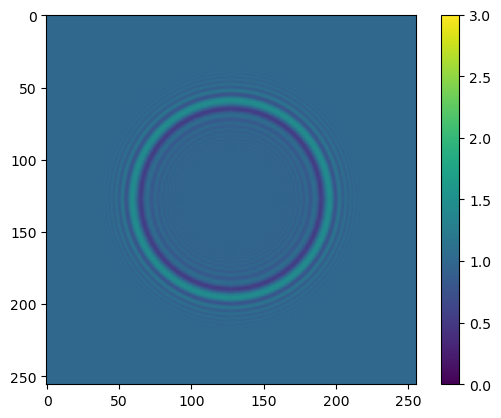

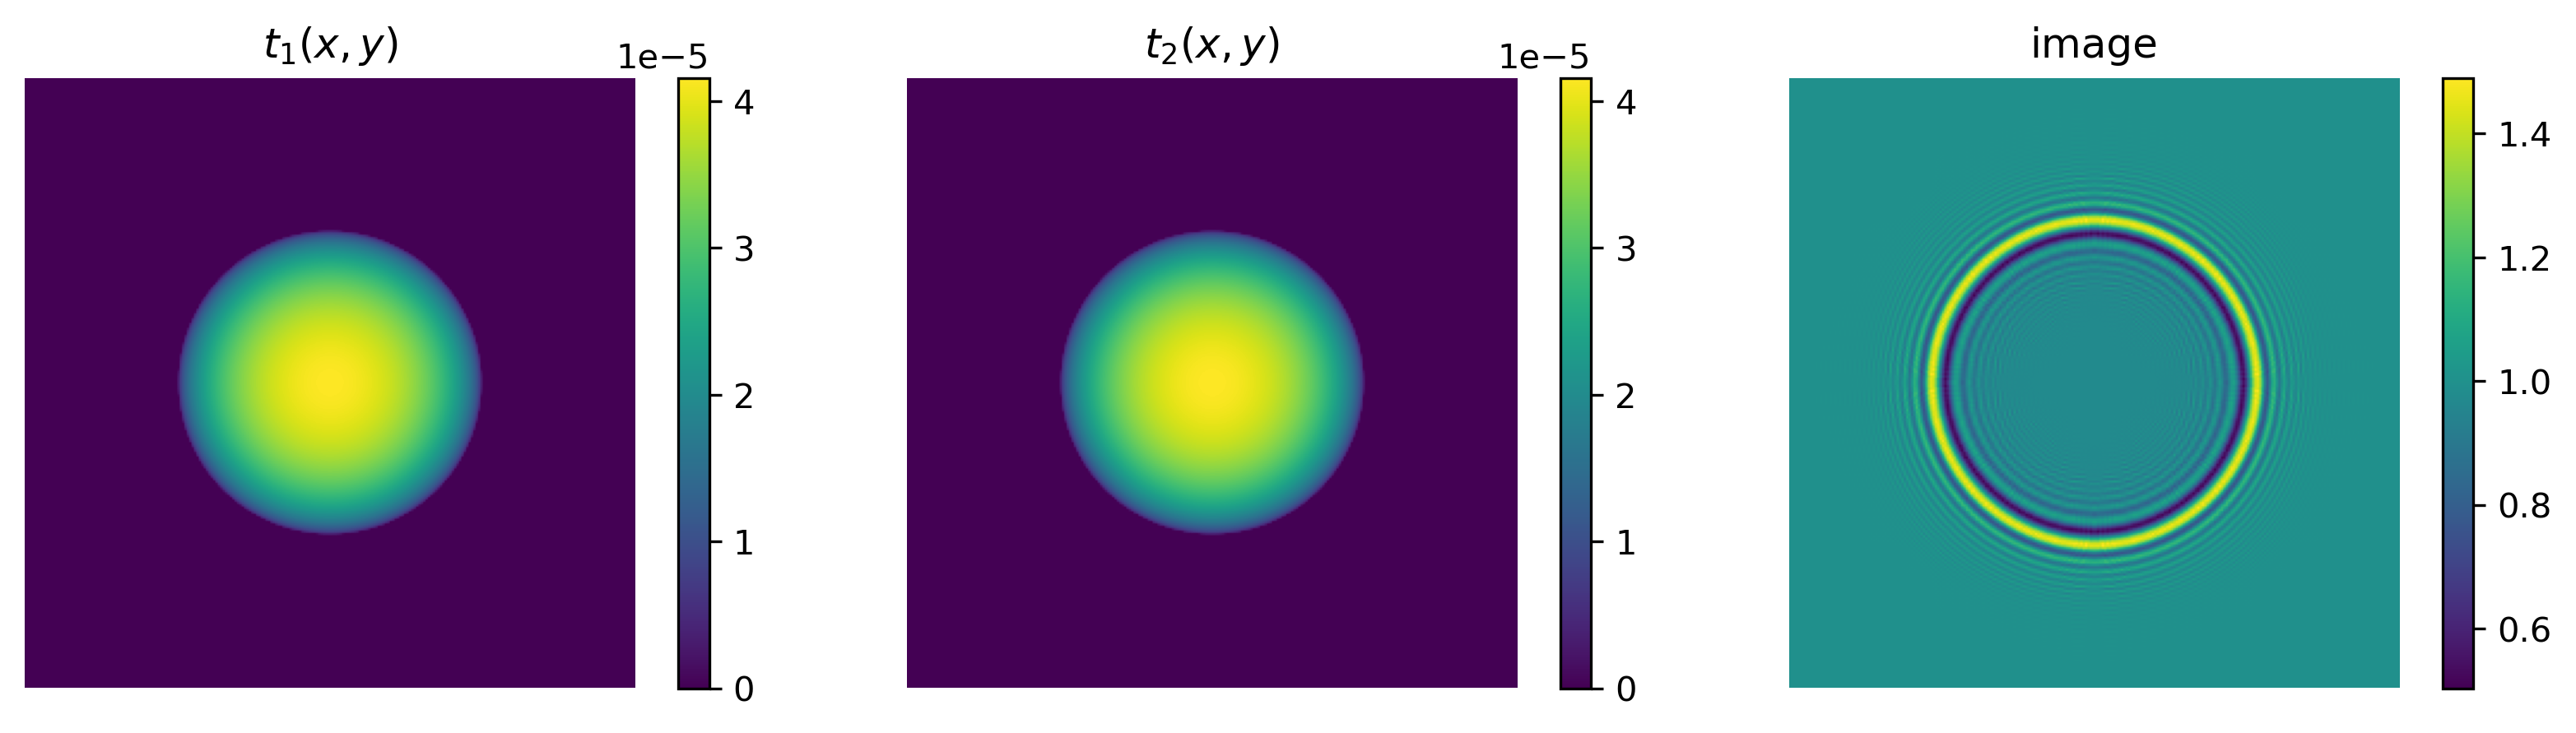

CPU times: user 1.95 s, sys: 25 µs, total: 1.95 s
Wall time: 1.98 s


In [522]:
%%time

E = 20.0
E_1, E_2 = 20.0, 20.0 #24.0, 34.0  # keV 
eta = 1.0 
N_photons = 1e6   # number of photons per acquisition, to distribute over grid
I_i = 1 # normally func of N_phot

## grid - symmetric (for now)
N_points0 = 128
px_sz0 = .65e-6
dx = .1e-6  # finite-difference partial derivatives

## material 1
r_1 = FOV/4 #20e-6 #.5e-3  
matname_1 = 'Aluminum'
matcomp_1 = 'Al(1.0)'  
density_1 = 2.699 # g/cm^3

## material 2
r_2 = FOV/4 #20e-6 #.8e-3
matname_2 = 'PMMA'
matcomp_2 = 'H(8.0541)C(59.9846)O(31.9613)' 
density_2 = 0.00001 #1.19 # g/cm^3

# from mohan
# Refractive index decrements for SiC, Teflon (C2F4), Al2O3, Polyimide (C22H10N2O5).
delta_gt = [1.67106361e-6, 1.09720611e-6, 2.02572255e-6, 7.61298395e-7]
# Absorption indices for SiC, Teflon (C2F4), Al2O3, Polyimide (C22H10N2O5).
beta_gt = [4.77064388e-9, 9.08938758e-10, 3.97340827e-9, 3.21013771e-10]

### set up the inputs
#for upsampx in [2]:
for ind in [0]:#,1,2,3]:
    FOV = N_points0*px_sz0
    N_points = N_points0*upsampx
    px_sz = px_sz0/upsampx
    x_vals = np.linspace(-FOV/2, FOV/2, N_points).astype(np.float32) 
    wavelen = get_wavelen(E)
    print(f'{N_points}x{N_points} grid \t {FOV:.1e} m FOV \t {px_sz:.1e} m px \t {I_i:.1e} photons/px, {r_1:.1e} m radius')
    
    t_1 = get_t_j_grid(x_vals, x_vals, r_1)
    t_2 = get_t_j_grid(x_vals, x_vals, r_2)
    #delta_1, beta_1 = get_delta_beta_mix(matcomp_1, E, density_1) 
    #delta_2, beta_2 = get_delta_beta_mix(matcomp_2, E, density_2)  

    delta_1, beta_1 = delta_gt[1], beta_gt[1]
    delta_2, beta_2 = delta_gt[3], beta_gt[3]

    prop_dist = 100e-3 
    exit_wave = modulate_wave(I_i, wavelen, t_1, t_2, delta_1, beta_1, delta_2, beta_2)
    det_wave = propagate_wave(exit_wave, prop_dist, wavelen, px_sz, px_sz)

    #sig0 = downsample2(np.abs(det_wave), upsampx)

    
    sig = get_m_mono_fresnel(r_1, r_2, 1, E, prop_dist, beta_1, delta_1, beta_2, delta_2, x_vals, px_sz, upsampx=upsampx)
    #dsig_dA = get_dm_dA_mono_fresnel(dx, 0, r_1, r_2, 1, E, prop_dist, mu_1, delta_1, mu_2, delta_2, x_vals, px_sz, upsampx=upsampx)
    # plt.imshow(sig)#, vmin=0, vmax=2)#, cmap='gray')
    # plt.colorbar()
    # plt.show()
    
    sig = np.abs(det_wave)
    plt.imshow(sig, vmin=0, vmax=3)
    plt.colorbar()
    plt.show()
    
    test_plot_objsig(sig, r_1, r_2)

In [481]:
twavelen, wavelen

(3.646593911764706e-11, 6.199210188637758e-11)

0


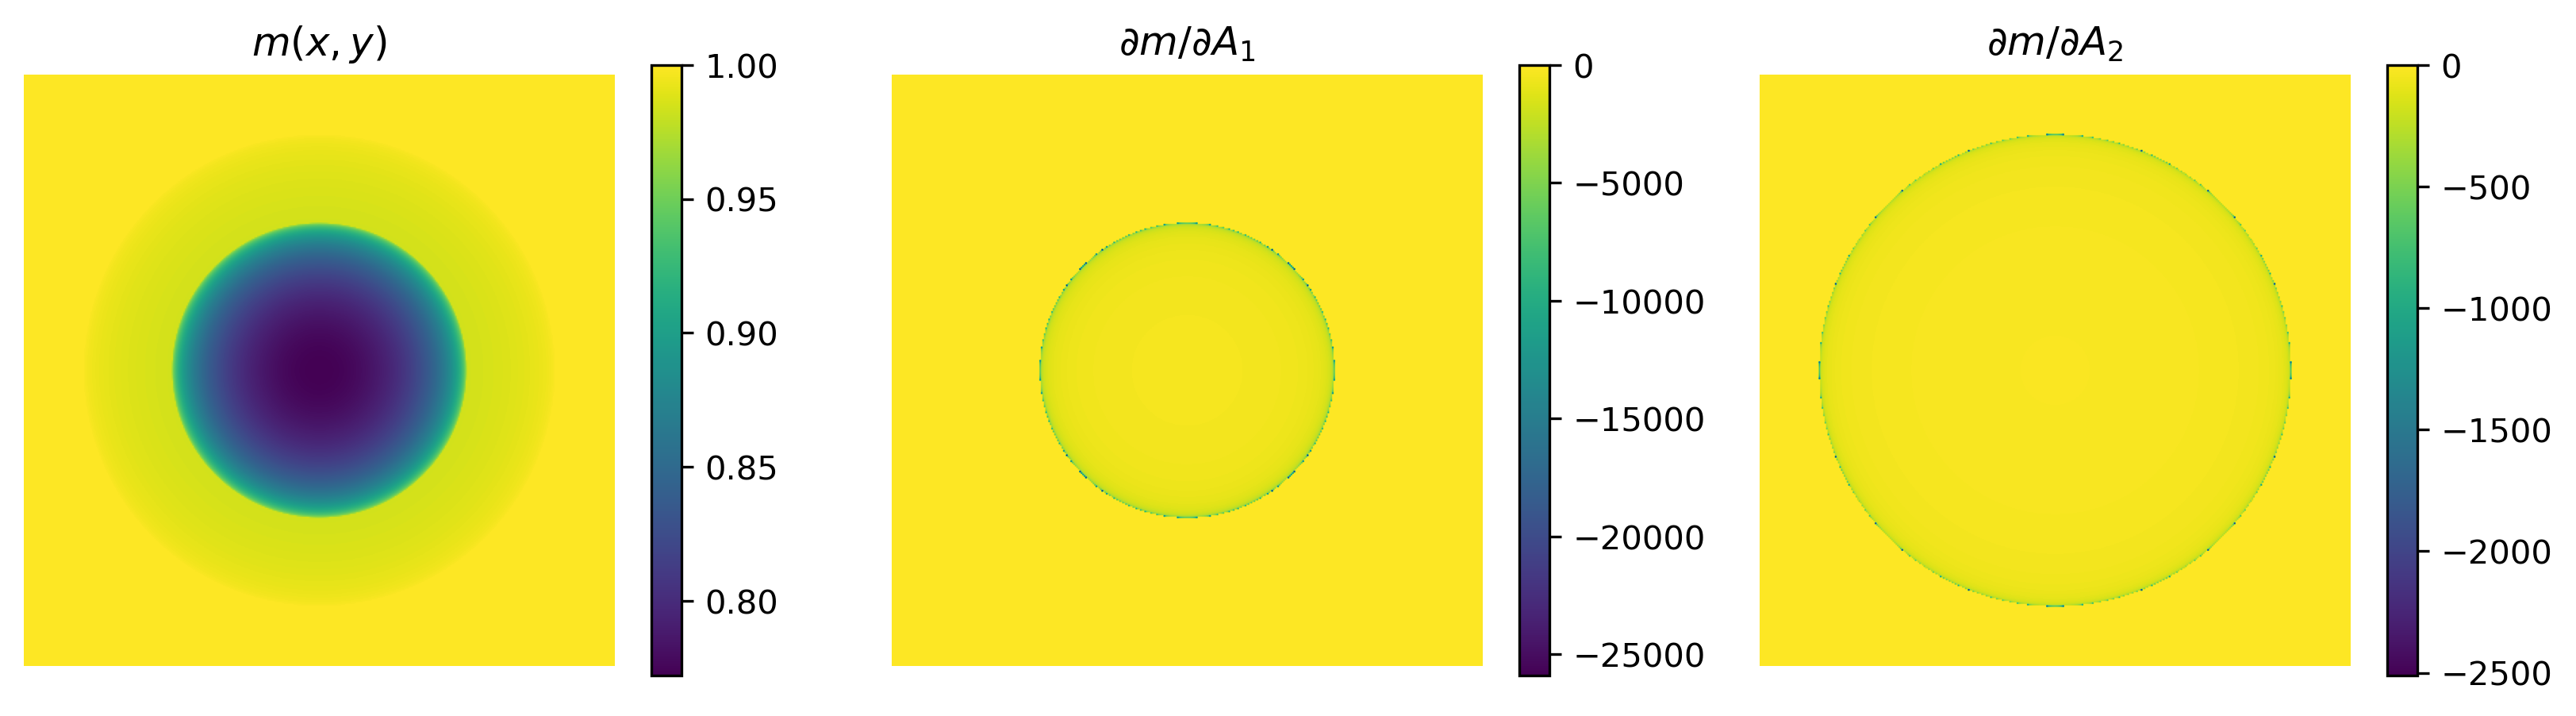

param 1 = 5.0e-04 	 stdev = 3.947e-06 	 --> 0.79%
param 2 = 8.0e-04 	 stdev = 4.319e-05 	 --> 5.40%
0.1


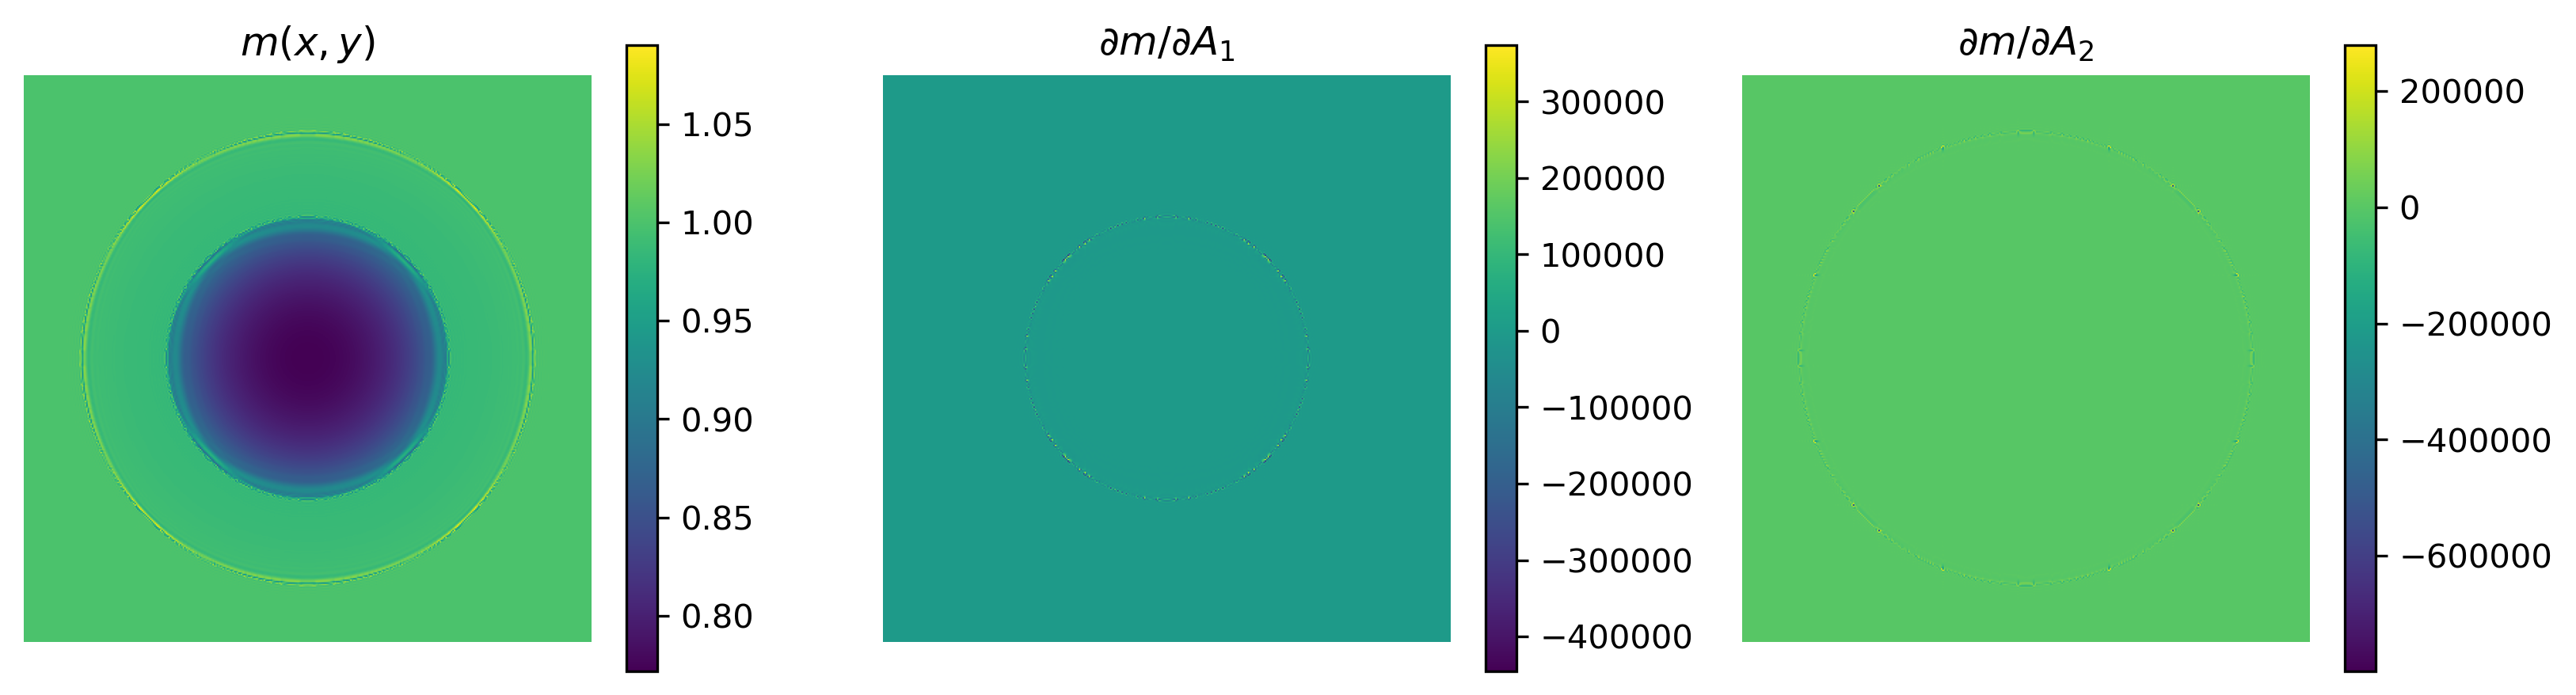

param 1 = 5.0e-04 	 stdev = 1.956e-07 	 --> 0.04%
param 2 = 8.0e-04 	 stdev = 2.572e-07 	 --> 0.03%
0.2


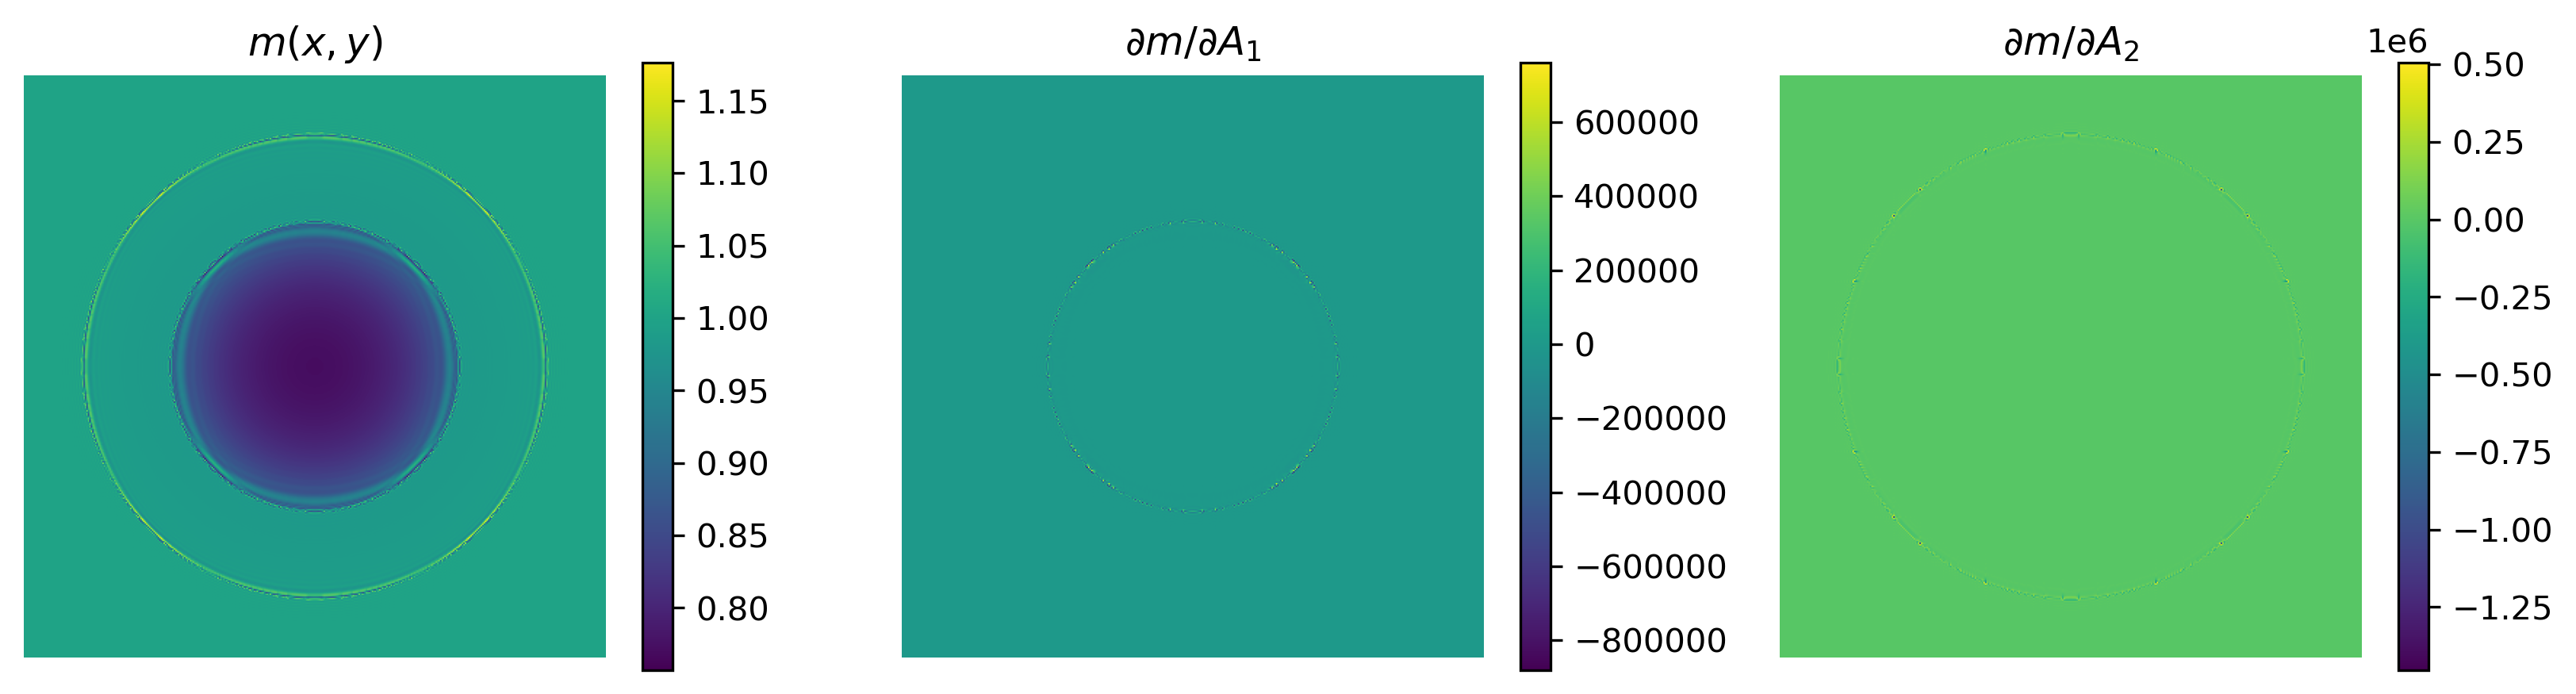

param 1 = 5.0e-04 	 stdev = 9.705e-08 	 --> 0.02%
param 2 = 8.0e-04 	 stdev = 1.358e-07 	 --> 0.02%
1.0


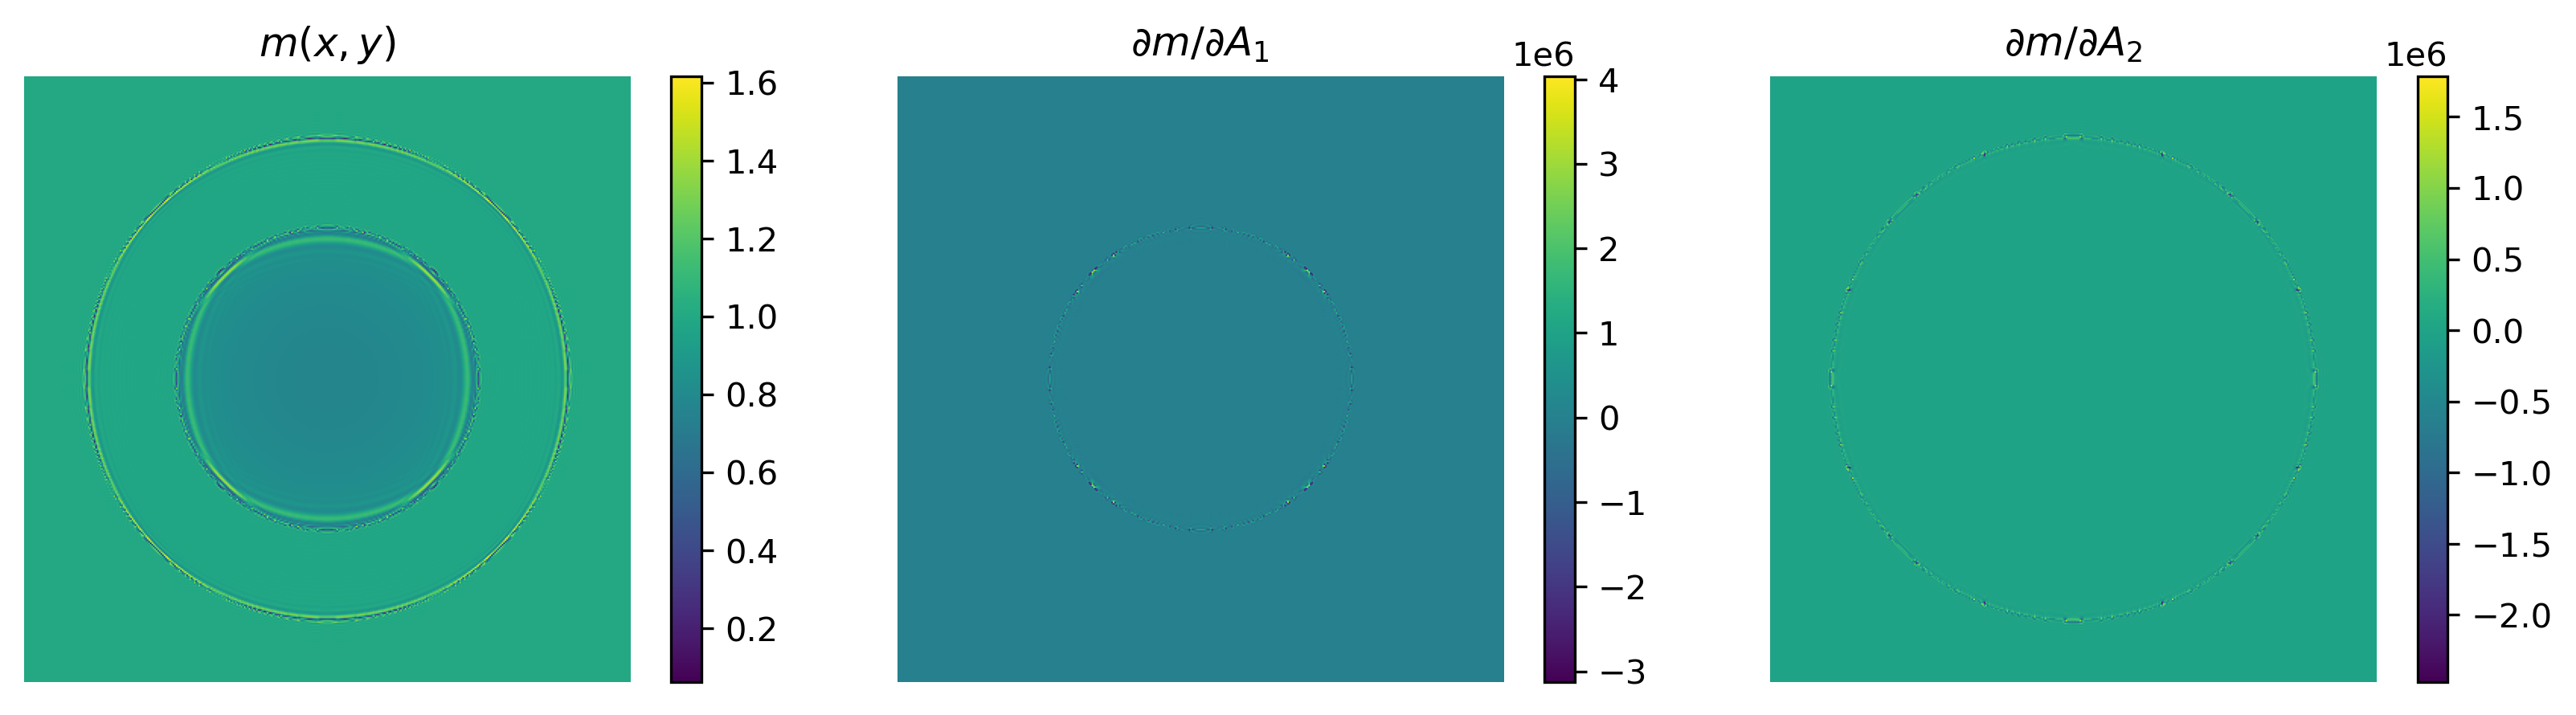

param 1 = 5.0e-04 	 stdev = 1.651e-08 	 --> 0.00%
param 2 = 8.0e-04 	 stdev = 3.092e-08 	 --> 0.00%
CPU times: user 25.7 s, sys: 13.3 ms, total: 25.7 s
Wall time: 25.7 s


In [81]:
%%time

for prop_dist in [0, 0.1, 0.2, 1.0]:
    print(prop_dist)

    ### init Fisher matrix
    F = np.zeros([2,2], dtype=np.float64) 
    
    ### parameter samplings
    delta_1, beta_1 = get_delta_beta_mix(matcomp_1, E, density_1) 
    delta_2, beta_2 = get_delta_beta_mix(matcomp_2, E, density_2)  
    mu_1 = 100*density_1*mixatten(matcomp_1, np.array([E_1]).astype(np.float64))[0] #m^-1
    mu_2 = 100*density_2*mixatten(matcomp_2, np.array([E_1]).astype(np.float64))[0] #m^-1
    
    ### compute the signal and partials
    
    sig = get_m_mono_fresnel(r_1, r_2, 1, E, prop_dist, mu_1, delta_1, mu_2, delta_2, x_vals, px_sz)
    dm_dA1 = get_dm_dA_mono_fresnel(dx, 0, r_1, r_2, 1, E, prop_dist, mu_1, delta_1, mu_2, delta_2, x_vals, px_sz)
    dm_dA2 = get_dm_dA_mono_fresnel(0, dx, r_1, r_2, 1, E, prop_dist, mu_1, delta_1, mu_2, delta_2, x_vals, px_sz)
    test_plot_sig(sig, dm_dA1, dm_dA2)
    
    ### add to crlb
    F[0,0] += np.sum(dm_dA1 * dm_dA1 / sig)
    F[0,1] += np.sum(dm_dA1 * dm_dA2 / sig)
    F[1,0] += np.sum(dm_dA2 * dm_dA1 / sig)
    F[1,1] += np.sum(dm_dA2 * dm_dA2 / sig)
    
    ### compute the crlb
    Fi = np.linalg.inv(F)
    crlb1 = Fi[0,0]
    crlb2 = Fi[1,1]
    s1 = np.sqrt(crlb1)
    s2 = np.sqrt(crlb2)
    
    print(f'param 1 = {r_1:.1e} \t stdev = {s1:.3e} \t SNR ~ {r_1/s1:.2f}%')
    print(f'param 2 = {r_2:.1e} \t stdev = {s2:.3e} \t SNR {r_2/s2:.2f}%')

#param 1 = 5.0e-04 	 stdev = 9.705e-08 	 --> 0.02%
#param 2 = 8.0e-04 	 stdev = 1.358e-07 	 --> 0.02%

# Scratch

In [55]:
# param archive! 
matname_1 = 'ICRU tissue'
matcomp_1 = 'H(10.2)C(14.3)N(3.4)O(70.8)Na(0.2)P(0.3)S(0.3)Cl(0.2)K(0.3)'  
density_1 = 1.0 # g/cm^3

matname_2 = 'ICRU bone'
matcomp_2 = 'H(3.4)C(15.5)N(4.2)O(43.5)Na(0.1)Mg(0.2)P(10.3)S(0.3)Ca(22.5)' 
density_2 = 1.92 # g/cm^3

matname_2 = 'water'
matcomp_2 = 'H(11.2)O(88.8)' 
density_2 = 1.0 # g/cm^3



## grid - symmetric (for now)
FOV = 1000.e-6
px_sz = 5.e-6  
dx = px_sz #1.e-6  # finite-difference partial derivatives

## material 1
r_1 = 400.e-6  
matname_1 = 'Aluminum'
matcomp_1 = 'Al(1.0)'  
density_1 = 2.699 # g/cm^3

## material 2
r_2 = 100.e-6  
matname_2 = 'PMMA'
matcomp_2 = 'H(8.0541)C(59.9846)O(31.9613)' 
density_2 = 1.19 # g/cm^3


ee = 200.0
wavelen = 1e-3*h*c/(ee*J_eV) # m 
dd, bb = get_delta_beta_mix('H(11.2)O(88.8)' , np.array([ee]), 1.0)
uu = 2*np.pi*bb/wavelen #/ m^-1
print(uu, 2*uu)  # per m


[0.01622932] [0.03245864]


In [5]:
name = 'Al(1.0)'
 
matnames = []
weights = []

ii = 0
sub = name
lp = sub.find('(')
rp = sub.find(')')
while lp != -1:
    matnames.append(sub[:lp])
    weights.append(float(sub[(lp+1):rp]))
    ii = rp+1
    sub = sub[ii:]
    lp = sub.find('(')
    rp = sub.find(')')
    
# normalize weights
weights = np.array(weights)
weights = weights/np.sum(weights)

matnames, weights 

(['Al'], array([1.]))

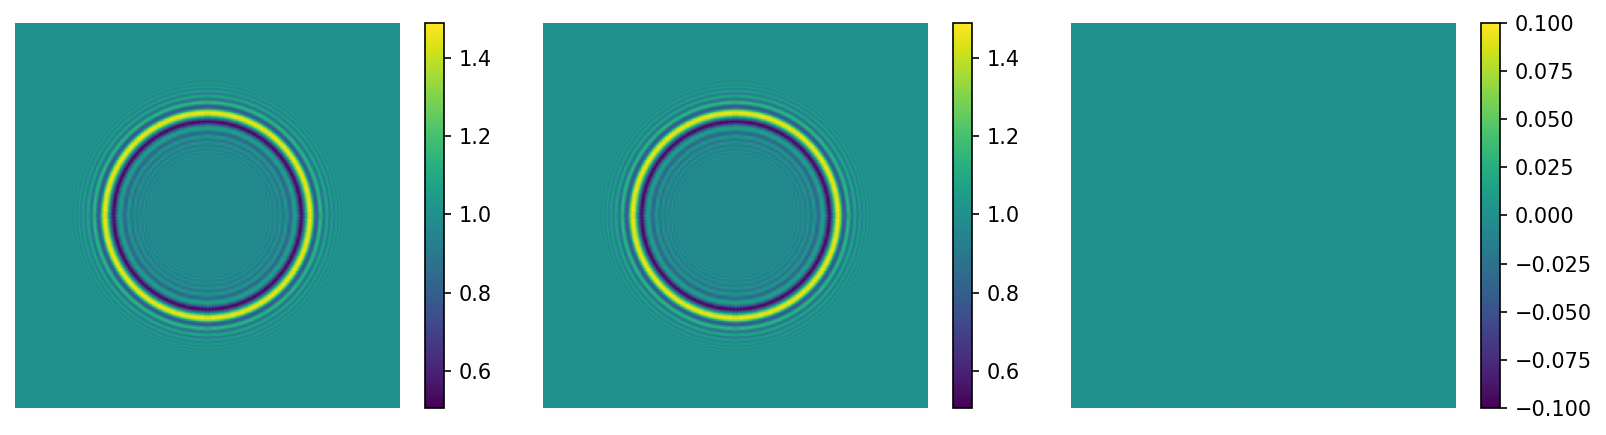

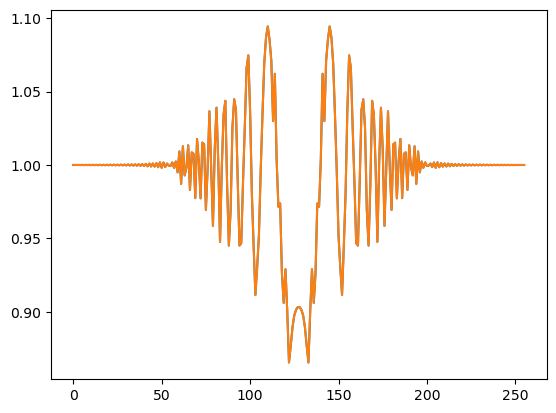

In [561]:

sampx = 1
block1 = np.abs(block_mean_2d(det_wave, sampx))
block2 = downsample2(np.abs(det_wave), sampx) #block_mean_2d(np.abs(det_wave), sampx)
#block3 = np.sqrt(block_mean_2d(det_wave.real, sampx)**2 + block_mean_2d(det_wave.imag, sampx)**2)  # equiv to block1
block3 = block1 - block2

fig, ax = plt.subplots(1,3,dpi=150, figsize=[11,3])
for i, img in enumerate([block1, block2-block3, block3]): 
    m = ax[i].imshow(img)
    fig.colorbar(m, ax=ax[i])
    ax[i].axis('off')
fig.tight_layout()
plt.show()

plt.plot(block1[50])
plt.plot(block2[50])

In [539]:
## block mean test

def block_mean_2d(arr, Nblock):
    '''
    Computes the block mean over a 2D array `arr`
    in sublocks of size Nblock x Nblock.
    If an axis size of arr is not an integer multiple 
    of Nblock, then zero padding is added at the end.
    '''
    Ny, Nx = arr.shape

    # add padding if needed
    padx, pady = 0, 0
    if Nx%Nblock != 0:
        padx = Nblock - Nx%Nblock
    if Ny%Nblock != 0:
        pady = Nblock - Ny%Nblock
    arr_pad = np.pad(arr, [(0, pady), (0, padx)])
    Ny, Nx = arr_pad.shape

    # compute block mean
    block_mean = arr_pad.reshape(Ny//Nblock, Nblock, Nx//Nblock, Nblock).mean(axis=(1,-1))
    return block_mean

    
test = np.ones([12,9])
test, block_mean_2d(test, 4)

(array([[1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1.  , 1.  , 0.25],
        [1.  , 1.  , 0.25],
        [1.  , 1.  , 0.25]]))